# Import Package

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [23]:
df = pd.read_csv("data/train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


,missing_value,%
battery_power,0,0.0
blue,0,0.0
clock_speed,0,0.0
dual_sim,0,0.0
fc,0,0.0
four_g,0,0.0
int_memory,0,0.0
m_dep,0,0.0
mobile_wt,0,0.0
n_cores,0,0.0


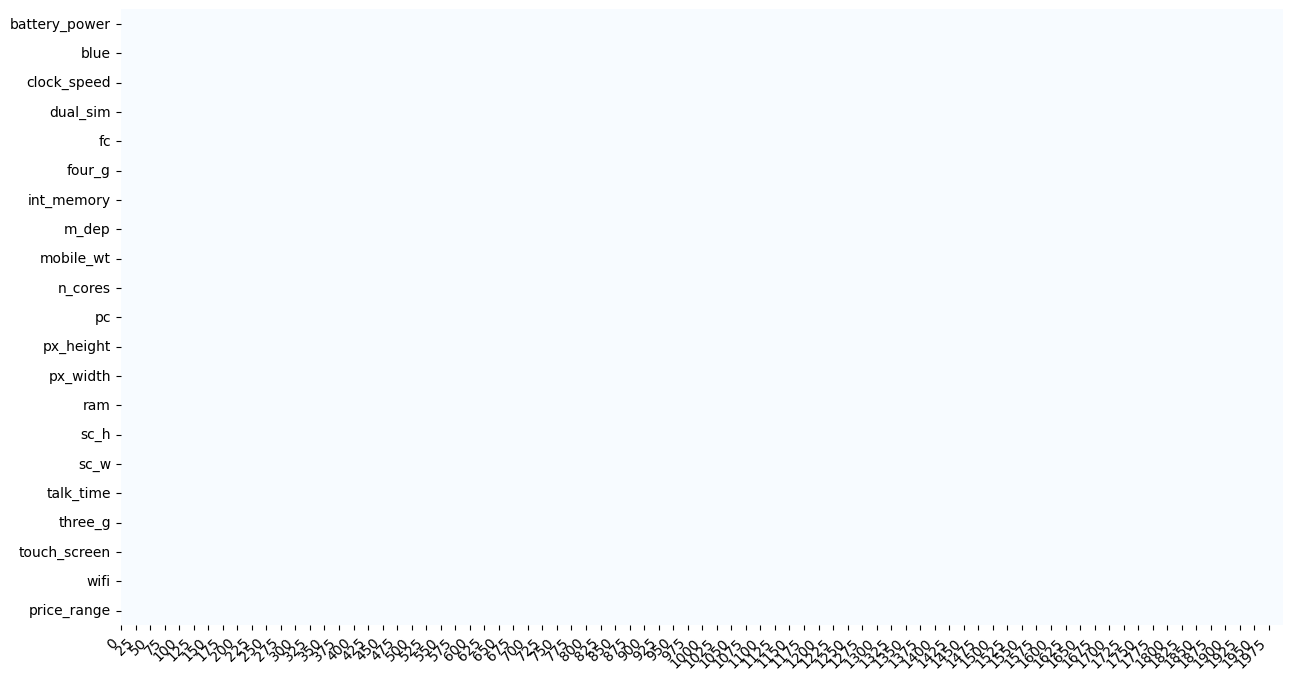

In [24]:
plot_missing_value(df, return_df=True)

# Dataset Splitting

In [25]:
X = df.drop(columns="price_range")
y = df.price_range

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 20), (400, 20), (1600,), (400,))

# Training

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [27]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ["battery_power", "clock_speed", "fc", 'int_memory',
                             'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
                             'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time',]),
    ('categoric', cat_pipe(encoder='onehot'), ["blue", "dual_sim", "four_g", "three_g", "touch_screen", "wifi"]),
    ])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__C': 80.92609705736085, 'algo__fit_intercept': True}
0.98625 0.9662511447932111 0.98


# Evaluation

In [28]:
from jcopml.feature_importance import mean_score_decrease

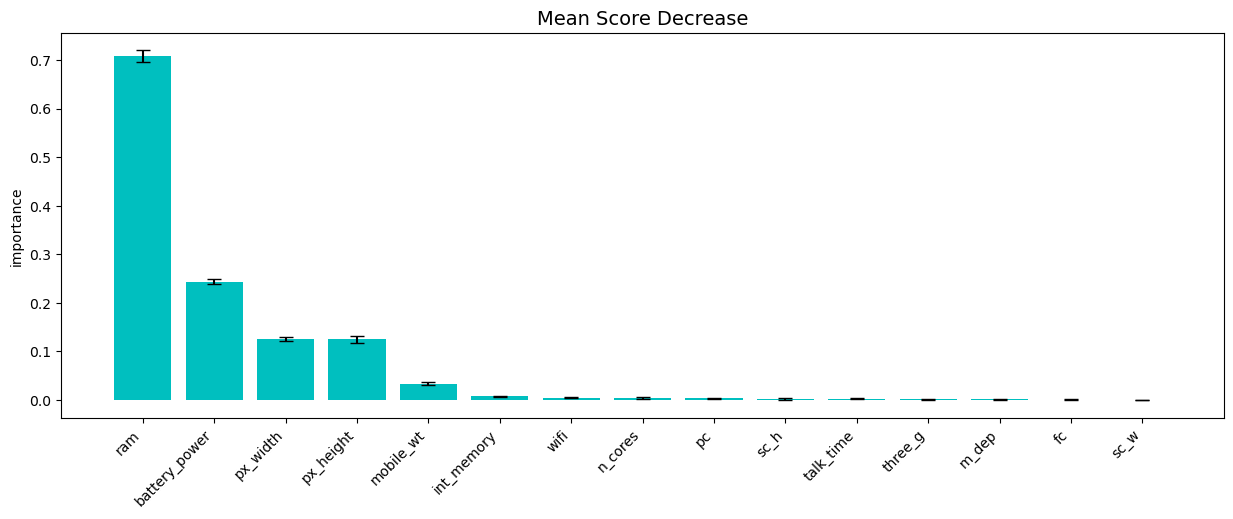

In [29]:
feature_importance = mean_score_decrease(X_train, y_train, model, plot=True, topk=15)

In [30]:
print(feature_importance)

          feature  importance     stdev
13            ram    0.708250  0.011507
0   battery_power    0.243250  0.005610
12       px_width    0.125250  0.004268
11      px_height    0.124500  0.006572
8       mobile_wt    0.033625  0.002778
6      int_memory    0.007125  0.001346
19           wifi    0.004875  0.001392
9         n_cores    0.004125  0.001403
10             pc    0.003125  0.000791
14           sc_h    0.002750  0.002000
16      talk_time    0.002500  0.001369
17        three_g    0.001125  0.000468
7           m_dep    0.000875  0.001879
4              fc    0.000625  0.000685
15           sc_w    0.000250  0.000306


In [31]:
feature = feature_importance["feature"].tolist()
feature_importance = feature[:4 + 1]

In [32]:
new_X = X[feature_importance]

# Training Model with new feature importance

In [33]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, stratify=y, random_state=42)

In [34]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ['ram', 'battery_power', 'px_width', 'px_height', 'mobile_wt']),
    ])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__C': 124.01749234666266, 'algo__fit_intercept': True}
0.97625 0.969999976577121 0.99


# Test Model

In [41]:
df_test = pd.read_csv("data/test.csv")

df_test = df_test[feature_importance]

y_pred = model.predict(df_test)
y_pred_df = pd.DataFrame(y_pred, columns= ["predicted"])
y_pred_df.head(10)

,predicted
0,3
1,3
2,2
3,3
4,1
5,3
6,3
7,1
8,3
9,0
